# ch19_3 text classification

이미지와 마찬가지로 텍스트 데이터도 분류가 가장 기본적인 테스크입니다. 긍정적인 리뷰와 부정적인 리뷰로 분류하는 모델을 만들어보겠습니다.

## 사전 작업

### 데이터 셋 준비

In [7]:
import pandas as pd

train_df = pd.read_csv("./data/naver_reviews_train.csv")
val_df = pd.read_csv("./data/naver_reviews_test.csv")

train_df = train_df.dropna()
val_df = val_df.dropna()

### tokenizer 준비

In [8]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./data/tokenizer.json")

In [9]:
tokenizer.encode("최고의 영화!").tokens

['최고의', '영화', '!']

## 데이터 전처리

텍스트 데이터 셋도 이미지 데이터 셋과 마찬가지로 dataset과 dataloader가 필요합니다. 그리고 텍스트를 텐서로 변환하는 전처리 로직도 필요합니다. 우선 간단하게 dataset과 dataloader를 만들어주겠습니다.

### Dataset, DataLoader

In [10]:
from torch.utils.data import Dataset

class CustomTextDataset(Dataset):
    def __init__(self, corpus_df):
        self.corpus_df = corpus_df
    
    def __len__(self):
        return len(self.corpus_df)
    
    def __getitem__(self, idx):
        text, label = self.corpus_df.iloc[idx]
        return text, label

In [12]:
train_dataset = CustomTextDataset(train_df)
val_dataset = CustomTextDataset(val_df)

In [13]:
train_dataset[0]

('아 더빙.. 진짜 짜증나네요 목소리', 0)

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)

In [16]:
train_iterator = iter(train_dataloader)
batch = next(train_iterator)

In [17]:
batch

[('어릴때 보았던 무협영화중 최고였다.그 이후, 다 커서 다시 봤는데도 또 재미있었던 작품이다.',
  '돈주고보면 돈이아깝고 공짜로보면 시간이아까운듯',
  '망하는데는 다이유가있다.망해도 싸다!',
  '애니메이션 판도를 바꿔놓았다'),
 tensor([1, 0, 0, 1])]

텍스트 데이터의 특징은 문장들 간에 길이가 다르다는 것입니다. 즉, 문장을 토큰화화면 길이가 달라집니다. 배치에 들어있는 텍스트 데이터를 토큰화 해보겠습니다.

In [18]:
import torch

def tokenize(text):
    tokens = tokenizer.encode(text).ids
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    return token_tensor

In [19]:
batch_text = batch[0]

In [21]:
batch_tensor = [tokenize(x) for x in batch_text]

In [22]:
batch_tensor

[tensor([6141, 9998, 6959, 6147, 8375,    7,  219, 5779,    6,  525, 2152, 2584,
         4943, 8647,  724, 4922, 5120, 7699,    7]),
 tensor([6105, 5277, 6193, 5494, 2630, 9378, 5277, 5289, 7285, 2936]),
 tensor([ 924, 5399, 2617, 8152, 3043, 2587, 5344,    7,  924, 5363, 1445, 2599,
            4]),
 tensor([5526, 2328, 8484, 7783, 3014, 5048])]

### Padding

위 예시에서 data loader가 batch size만큼 문장을 읽어왔습니다. 그리고 이를 토큰화 하였는데, 문장마다 길이가 다르기 때문에 토큰 개수도 다릅니다. 이를 하나의 텐서로 묶어주기 위해서는 가장 긴 문장의 길이를 기준으로 나머지 문장들에 패딩을 추가해주어야 합니다. 

먼저 패딩에 해당하는 토큰을 확인해보겠습니다.

In [27]:
vocabs = tokenizer.get_vocab()
pad_token = vocabs["[PAD]"]

In [28]:
pad_token

0

torch에 내장되어 있는 pad_sequence 기능을 이용해서 패딩을 채워보겠습니다.

In [30]:
batch_tensor

[tensor([6141, 9998, 6959, 6147, 8375,    7,  219, 5779,    6,  525, 2152, 2584,
         4943, 8647,  724, 4922, 5120, 7699,    7]),
 tensor([6105, 5277, 6193, 5494, 2630, 9378, 5277, 5289, 7285, 2936]),
 tensor([ 924, 5399, 2617, 8152, 3043, 2587, 5344,    7,  924, 5363, 1445, 2599,
            4]),
 tensor([5526, 2328, 8484, 7783, 3014, 5048])]

In [32]:
from torch.nn.utils.rnn import pad_sequence

pad_sequence(batch_tensor, padding_value=pad_token)

tensor([[6141, 6105,  924, 5526],
        [9998, 5277, 5399, 2328],
        [6959, 6193, 2617, 8484],
        [6147, 5494, 8152, 7783],
        [8375, 2630, 3043, 3014],
        [   7, 9378, 2587, 5048],
        [ 219, 5277, 5344,    0],
        [5779, 5289,    7,    0],
        [   6, 7285,  924,    0],
        [ 525, 2936, 5363,    0],
        [2152,    0, 1445,    0],
        [2584,    0, 2599,    0],
        [4943,    0,    4,    0],
        [8647,    0,    0,    0],
        [ 724,    0,    0,    0],
        [4922,    0,    0,    0],
        [5120,    0,    0,    0],
        [7699,    0,    0,    0],
        [   7,    0,    0,    0]])

패딩을 채워보면 하나의 열에 문장 하나의 토큰 값들이 담기게 됩니다. 가장 긴 문장의 길이만큼 나머지 문장들에는 패딩이 채워진 모습을 확인할 수 있습니다.

### collate_fn

이렇게 텍스트를 토큰화 하고, 배치 단위로 패딩을 채워넣었습니다. 그런데 패딩을 채우기 위해서는 배치 내에서 가장 길이가 긴 문장의 토큰 수를 알아야 합니다. 즉, 데이터 셋에서 데이터 로더가 배치 사이즈만큼 데이터를 가져오는 시점에 텍스트를 토큰화하고, 패딩을 채우는 작업을 수행해주어야 합니다. 이러한 작업을 수행해주는 역할을 묶어주는 함수, collate_fn이라고 부릅니다.

collate 함수 안에서는 데이터를 토큰화 해주고, 패딩을 채워주는 작업을 진행합니다. 이 때, 특정 문장의 길이가 지나치게 긴 경우를 예방하기 위해 최대 토큰 길이 값을 지정해줍니다.

In [33]:
MAX_TOKENS = 256
BATCH_SIZE = 128

In [40]:
def collate_fn(batch):
    def _tokenize(text):
        tokens = tokenizer.encode(text).ids
        tokens = tokens[:MAX_TOKENS]
        token_tensor = torch.tensor(tokens, dtype=torch.long)
        return token_tensor
    
    batch_text = [x[0] for x in batch]
    batch_label = torch.tensor([x[1] for x in batch], dtype=torch.long)
    batch_tokens = [_tokenize(x) for x in batch_text]
    batch_padded = pad_sequence(batch_tokens, padding_value=pad_token)
    return batch_padded, batch_label

In [48]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn
)

In [49]:
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    collate_fn=collate_fn
)

In [46]:
train_iterator = iter(train_dataloader)

In [58]:
next(train_iterator)[0].shape

torch.Size([67, 128])

## 모델 학습

### 모델 작성

이제 텍스트를 분류하는 딥러닝 모델을 만들어보겠습니다. 모델의 구조는 아래와 같습니다.

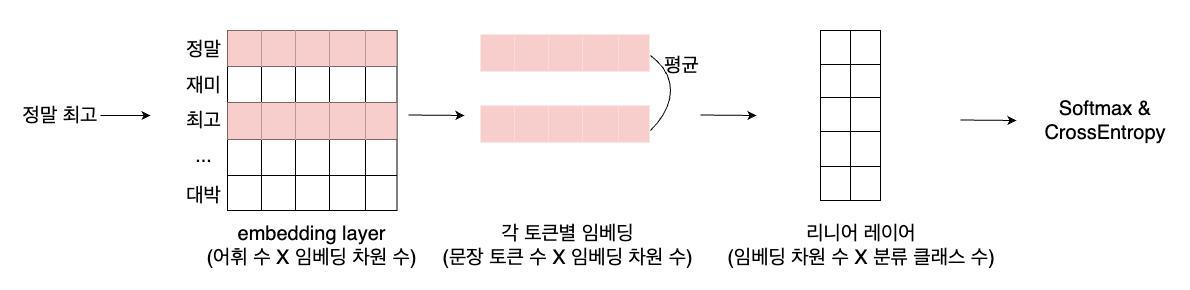

먼저 토큰화 한 문장을 embedding layer를 통과시켜 각 토큰별 임베딩 벡터를 가져옵니다. 각 토큰별로 128 차원의 임베딩을 갖도록 하고, 현재 tokenizer는 총 8000개의 토큰을 가지고 있으므로 임베딩 레이어는 8000 X 128이 됩니다. 이제 문장에 포함된 토큰만 가져온 뒤, 평균을 냅니다. 그리고 이를 리니어 레이어를 하나 통과시킨 뒤, 학습을 시켜보겠습니다. 

In [60]:
from torch import nn

class TextClassification(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.fc = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=0)
        x = self.fc(x)
        return x

In [61]:
VOCAB_SIZE = len(tokenizer.get_vocab())
EMBEDDING_DIM = 128
OUTPUT_DIM = 2

In [62]:
model = TextClassification(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    output_dim=OUTPUT_DIM
)

In [63]:
model

TextClassification(
  (embedding): Embedding(10000, 128)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

### 학습 코드 준비

기존 모델 학습에 사용했던 코드를 재사용하여 학습을 진행해보겠습니다.

In [64]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [65]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [66]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [67]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [68]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

### 하이퍼 파라미터 셋팅 

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

### 학습

In [70]:
logs = train_validate_model(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 127.18it/s]


epoch 1 train - loss: 0.5951 acc: 0.7065 val - loss: 0.4841 acc: 0.8024


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 128.25it/s]


epoch 2 train - loss: 0.4209 acc: 0.827 val - loss: 0.403 acc: 0.8307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 128.14it/s]


epoch 3 train - loss: 0.3691 acc: 0.8455 val - loss: 0.3808 acc: 0.8396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 127.43it/s]


epoch 4 train - loss: 0.3484 acc: 0.8533 val - loss: 0.3743 acc: 0.8416


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 124.02it/s]


epoch 5 train - loss: 0.338 acc: 0.8574 val - loss: 0.3697 acc: 0.8436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 124.64it/s]


epoch 6 train - loss: 0.3312 acc: 0.86 val - loss: 0.3683 acc: 0.8442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 127.54it/s]


epoch 7 train - loss: 0.3272 acc: 0.8618 val - loss: 0.3683 acc: 0.8442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 125.08it/s]


epoch 8 train - loss: 0.3239 acc: 0.8634 val - loss: 0.3687 acc: 0.8443


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 127.53it/s]


epoch 9 train - loss: 0.3221 acc: 0.8638 val - loss: 0.3696 acc: 0.8441


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 126.50it/s]

epoch 10 train - loss: 0.3203 acc: 0.8648 val - loss: 0.3739 acc: 0.8387


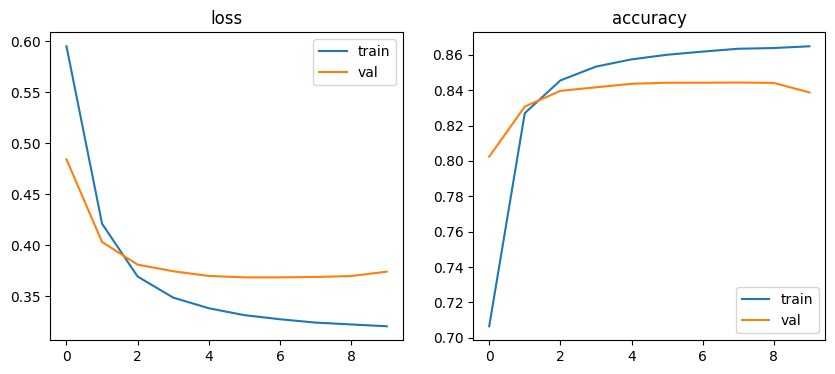

In [71]:
plot_logs(logs)

## 정리

이번 챕터에서는 텍스트 데이터를 DataLoader를 이용해서 텐서로 변환하고, Embedding Layer와 Fully Connected Layer를 이용해서 분류 모델을 학습시키는 작업을 수행해보았습니다. 그 결과 84% 정도의 성능을 얻을 수 있었습니다.